# Group Analysis of ERP Data

In [67]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import matplotlib.pyplot as plt
import numpy as np

Create a dictionary of Evokeds whose keys are conditions, and values are lists of `Evoked` objects. Each list should contain the `Evoked` objects from all participants.

Remember that in the previous step, you passed each participant's data as a list of Evokeds when you ran `write_evokeds()`. Here when you `read_evokeds()` you will likewise get a list of evokeds. Since each participant's data was saved in the same order, index 0 in the list will always be the same condition for all participants. For this reason, you can use `enumerate()` to loop over conditions and build your dictionary of `Evoked` objects here.

In [3]:
participants = [13, 14, 16, 19, 20, 21, 22, 23, 24, 25]
conditions = ['Match', 'Mismatch']

evokeds = {}

for i, c in enumerate(conditions):
    evokeds[c] = [mne.read_evokeds('data_out/' + 'l2_' + str(p) + '_post' + '-ave.fif')[i] for p in participants]

In [4]:
evokeds

{'Match': [<Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D' (average, N=72), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
  <Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D' (average, N=72), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
  <Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D' (average, N=72), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
  <Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D' (average, N=72), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
  <Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D' (average, N=72), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
  <Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.24 × Match/C + 0.25 × Match/D' (average, N=71), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
  <Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D' (aver

In [5]:
evokeds['Match'][0]

<Evoked | '0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D' (average, N=72), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>

## Compare Evoked waveforms

`mne.viz.plot_compare_evokeds()` will recognize a dictionary of Evoked objects and use the keys as condition labels. Furthermore, when it sees that each value in the dictionary is a list of Evoked objects, it will combine them and plot not only the mean across the list (i.e., across participants, for each condition), but also the 95% confidence intervals (CIs), representing the variability across participants.

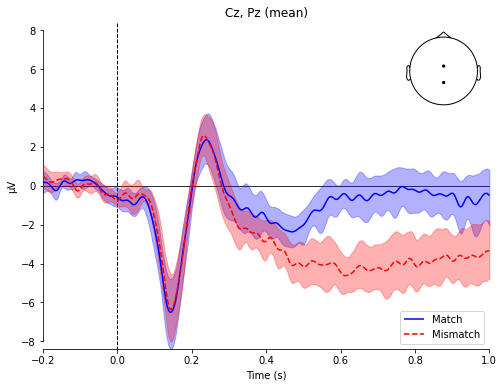

In [31]:
roi = ['Cz', 'Pz']

color_dict = {'Match':'blue', 'Mismatch':'red'}
linestyle_dict = {'Match':'-', 'Mismatch':'--'}


mne.viz.plot_compare_evokeds(evokeds, combine='mean',
                            legend='lower right',
                                 picks=roi, show_sensors='upper right',
                                 colors=color_dict,
                                 linestyles=linestyle_dict,
                            )
plt.show()

## Differences

In [36]:
evokeds_diff = []

for p in participants:
    dat = mne.read_evokeds('data_out/' + 'l2_' + str(p) + '_post' + '-ave.fif')
    evokeds_diff.append(mne.combine_evoked(dat, weights=[-1, 1]))

In [37]:
evokeds_diff

[<Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D) + (0.25 × Mismatch/A + 0.25 × Mismatch/B + 0.25 × Mismatch/C + 0.25 × Mismatch/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
 <Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D) + (0.25 × Mismatch/A + 0.25 × Mismatch/B + 0.25 × Mismatch/C + 0.25 × Mismatch/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
 <Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D) + (0.25 × Mismatch/A + 0.25 × Mismatch/B + 0.25 × Mismatch/C + 0.25 × Mismatch/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
 <Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D) + (0.26 × Mismatch/A + 0.25 × Mismatch/B + 0.24 × Mismatch/C + 0.25 × Mismatch/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
 <Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25

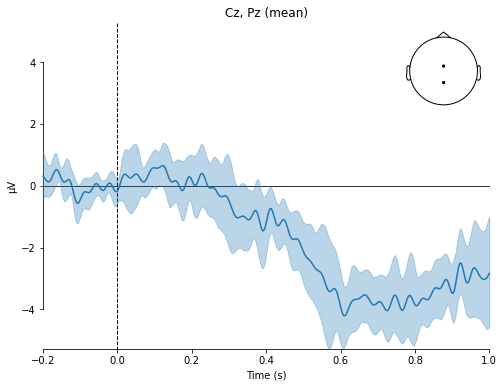

In [54]:
mne.viz.plot_compare_evokeds({'Mismatch-Match':evokeds_diff}, combine='mean',
                            legend=None,
                            picks=roi, show_sensors='upper right'
                            )
plt.show()

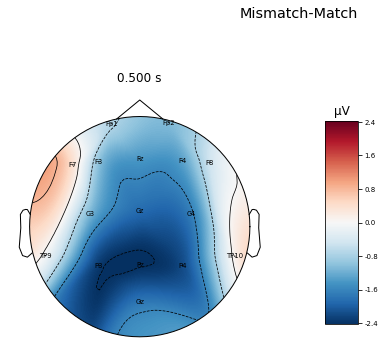

In [53]:
mne.viz.plot_evoked_topomap(mne.grand_average(evokeds_diff), 
                            times=.500, average=0.200, 
                            title='Mismatch-Match',
                            show_names=True,
                            size=3
                           );

## *t*-test over time window

In [55]:
X = evokeds_diff.get_data()

AttributeError: 'list' object has no attribute 'get_data'

In [56]:
evokeds_diff

[<Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D) + (0.25 × Mismatch/A + 0.25 × Mismatch/B + 0.25 × Mismatch/C + 0.25 × Mismatch/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
 <Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D) + (0.25 × Mismatch/A + 0.25 × Mismatch/B + 0.25 × Mismatch/C + 0.25 × Mismatch/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
 <Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D) + (0.25 × Mismatch/A + 0.25 × Mismatch/B + 0.25 × Mismatch/C + 0.25 × Mismatch/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
 <Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25 × Match/C + 0.25 × Match/D) + (0.26 × Mismatch/A + 0.25 × Mismatch/B + 0.24 × Mismatch/C + 0.25 × Mismatch/D)' (average, N=36.0), -0.2 – 1 sec, baseline -0.2 – 0 sec, 16 ch, ~105 kB>,
 <Evoked | '-(0.25 × Match/A + 0.25 × Match/B + 0.25

In [92]:
evoked_data = np.array([np.mean(e.get_data(picks='Pz', tmin=.400, tmax=.600), axis=1) for e in evokeds_diff])

In [94]:
evoked_data

array([[-6.80845559e-07],
       [-3.23693050e-06],
       [-4.81736369e-06],
       [-5.05396392e-06],
       [-2.27347437e-06],
       [-1.13360868e-06],
       [-1.15141147e-06],
       [-2.09595668e-06],
       [-2.47917652e-06],
       [-1.20236400e-06]])

In [97]:
from scipy import stats 
t, pval = stats.ttest_1samp(evoked_data, 0)
print('Difference t = ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Difference t =  -4.96 p =  0.0008


## Permutation *t*-test

Plots scalp topographic map of *p* values, and highlights channels where *t* test was significant in white

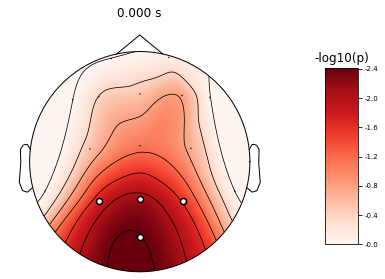

In [111]:
from mne.stats import permutation_t_test

evoked_data = np.array([np.mean(e.get_data(tmin=.400, tmax=.600), axis=1) for e in evokeds_diff])

n_permutations = 50000
T0, p_values, H0 = permutation_t_test(evoked_data, n_permutations, n_jobs=10)

evoked = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis],
                         evokeds[conditions[0]][0].info, tmin=0.)

mask = p_values[:, np.newaxis] <= 0.05

evoked.plot_topomap(times=[0], scalings=1,
                    time_format=None, cmap='Reds', vmin=0., vmax=np.max,
                    units='-log10(p)', cbar_fmt='-%0.1f', mask=mask,
                    size=3, show_names=lambda x: x[4:] + ' ' * 20,
                    time_unit='s')
plt.show()